# Policy Making in Malaria with AI (beta)

In most areas of public policy and decision making, it’s difficult to make evidence based decisions because of the difficulty involved in exploring options for truly complex decisions. Policy making in malaria is a good example of these complex decisions. In this notebook, we explore policy making with malaria by considering only two interventions space i.e. spraying and using bed nets with an open-malaria model for Rachuonyo South in Western Kenya. A reward function based on cost-effectiveness per Daly averted is used. 

This notebook is structured as follows:

 1. **Running the experiments with random actions** : In this section, we run several experiments with random actions and visualize the outcome reward by creating some MatPlotLib visualisations
 2. **Implementing Machine Learning and AI on models** : We implement a Genetic Algorithm Model after which we look at reward visualization with MatPlotLib

In [1]:
%load_ext autoreload
%autoreload 2    

import numpy as np

from netsapi.environment import *
from netsapi.location import *
from netsapi.register import *
from netsapi.visualisation import *
from es import SimpleGA, RemyGA

from multiprocessing import Pool, current_process
from sys import exit, exc_info, argv

# 1. Running the experiments with random actions

**User registration**

Let's us start with registration. Enter your details to create a user account

In [2]:
#User Details (Please enter your own :)
email = ""
institution = ""
names = ""
resolution, timeout, realworkercount = "test", 10, 100
# baseuri = "http://openmalaria-v2.eu-gb.mybluemix.net:80"
baseuri = "https://nlmodelflask.eu-gb.mybluemix.net"
#Currently provided public IP, we will enable users to install on their own environment with Docker shortly!

In [3]:
#Registration
userId = Register(email, institution, names, baseuri)
print('userId=', userId)

userId= 3bbb54d8-04ea-455f-b364-9dfde49167f7


**Model scenario**

Now that you are registered user, we are going to query locations/scenarios for our model input. Currently we have two locations available to test: 'zsp_sr_int' and 'rach_int_100'. To run the experiment, we obtain the location id for 'zsp_sr_int' as an example.

In [4]:
locations = showLocations(baseuri);
locationId = getLocationId(locations, 'zsp_sr_int')

rach_int_100
zsp_sr_int


**Running our first experiment!**

Let's start with initializing our experiment to generate our experiment id. Then we run a simulation describing a current intervention campaign 55% ITN and 70% IRS coverage and obtain our reward.

In [5]:
envId = initEnv(locationId, userId, resolution, baseuri)
# envId = initEnv('rach_int_100','1','test', 'https://nlmodelflask.eu-gb.mybluemix.net')
print('envId=', envId)
action = [0.55, 0.70] #[ITN, IRS]
reward = postAction(envId, action, baseuri, False, timeout)
# reward = postAction(envId, action, 'https://nlmodelflask.eu-gb.mybluemix.net', False, timeout)
rewards = np.append(action, reward)
print(reward)

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
envId= 3c102955-ca23-463b-8780-0846d202d016
-11.314494241127688


We have been able run an experiment successifully, let's define a few methods that will help us to run a few random experiments and observe the rewards

In [6]:
def individual_get_score(action):
    name_s=current_process().name
    id = np.mod(int(name_s.split("-")[1]),realworkercount)

    try:
        envId = initEnv(locationId, userId, resolution,baseuri)
        reward = postAction(envId, action%1, baseuri)
        print(id, action%1, reward)

    except:
        print(exc_info(),action)
        reward = None;
    
    return reward

def postActionWrapper(action):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
            id = -1
    try:
        envId = initEnv(locationId, userId, resolution, baseuri);
        posted = postAction(envId, action, baseuri, True, timeout)

    except:
        print(exc_info(),action)
    
    return envId if posted else None

def getStatusWrapper(envId):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
        id = -1
    try:
        status = getStatus(envId[0], baseuri)

    except:
        print(exc_info(),envId)
        status = None;
    
    return status

def getRewardWrapper(envId):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
        id = -1
    try:
        status = getReward(envId[0], baseuri)

    except:
        print(exc_info(),envId)
        status = None;
    
    return status

def map(function, data):
    if len(data.shape) == 2: #vector of chromosomes
        pool = Pool(realworkercount)
        result = pool.map(function, data)
        pool.close()
        pool.join()
    else:
        result = function(data)
    return result

def evaluateNonBlocking(data, coverage):
    try:
        completed = []
        envs = map(postActionWrapper, data)
        while len(completed) < coverage*data.shape[1]:
            statii = map(getStatusWrapper, np.array(envs).reshape(-1,1))
            completed = [i for i,v in enumerate(statii) if v == 'true']
            #print(len(completed), envs)
        rewardz = map(getRewardWrapper,np.array(envs).reshape(-1,1)[completed])
        val = data[completed], np.array(rewardz)
    except:
        print(exc_info(),data)
        val = None, None
    return val

def evaluate(data):
    if len(data.shape) == 2: #vector of chromosomes
        pool = Pool(realworkercount)
        result = pool.map(individual_get_score, data)
        pool.close()
        pool.join()
    else:
        result = individual_get_score(data)
    return result

**Running more experiments with random actions**

Let's run an experiment with 500 sets of random actions [ITN, IRS] and visualise the rewards as a simple scatter of points as a response surface (MatPlotLib may be required but you are free to visualise the data how you see fit)

In [7]:
rand_actions = np.random.rand(500,2) #3 random actions [ITN, IRS]
doneSolutions, doneRewards = evaluateNonBlocking(rand_actions, .8)

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

In [8]:
print(doneSolutions.shape, doneRewards.shape, rewards.shape)

(500, 2) (500,) (3,)


**Visualising rewards**

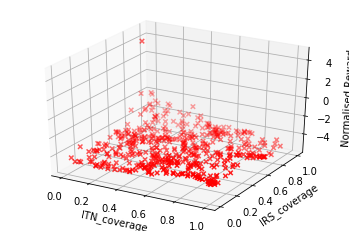

In [9]:
ResponseSurface(np.hstack((doneSolutions,doneRewards.reshape(-1,1))))

# 2. Implementing Machine Learning and AI on models

**Genetic Algorithm**

We use a parameter size of 2, a population size of 100 and consider 10 generations. For each generation we ask for random candidate parameters, calculate the reward and create a reward vector. We save all the results in a 3 dimensional vector space and aggregate for all generations.

In [10]:
num_paramters = 2

def mutate(chromosome):
    mutation_rate = .2
    for j in range(num_paramters):
        r = np.random.rand(1);
        if(r > mutation_rate):
            chromosome[j] = np.remainder(chromosome[j]+np.random.randn(1),0.99);
    return chromosome

def make_random_individuals(x,y):
    value=np.random.rand(x,y);
    return value


def boundary(individual):
    processed = np.clip(individual,0,1)
    return processed


solver = RemyGA(num_paramters,                # number of model parameters
            random_individuals_fcn=make_random_individuals,
            mutate_fcn = mutate,
            sigma_init=1,        # initial standard deviation
            popsize=100,   # population size
            elite_ratio=0.3,       # percentage of the elites
            forget_best=False,     # forget the historical best elites
            weight_decay=0.00,     # weight decay coefficient
             )

num_generations = 10
history=  np.empty(shape=(num_generations, solver.popsize, solver.num_params+1))
for i in range(num_generations):
    try:
        # ask for a set of random candidate solutions to be evaluated
        solutions = solver.ask()
        # calculate the reward for each given solution using our own method
        rewards = evaluate(solutions)
        solver.tell(rewards)

        # get best parameter, reward from ES
        reward_vector = solver.result()
        print(reward_vector[1],i, num_generations)
        history[i,:,:] = np.hstack((solutions,np.array(rewards).reshape(-1,1)))
        #np.save('results/%s'%(filename), history)
    except (KeyboardInterrupt, SystemExit):
        print(exc_info())

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

48 [0.40689486 0.84323486] 9.246117489708944
19 [0.83361992 0.65327086] 1.0576962353126187
98 [0.59617677 0.83000661] -40.721538063795045
20 [0.53601517 0.58542053] -1.6111756161994277
85 [0.04670557 0.32306802] -9.775266655771798
7 [0.36999567 0.15890824] 72.24805126575397
27 [0.2609434  0.65190539] -3.8575331553069567
61 [0.83754067 0.21677025] -16.868336223022595
21 [0.50329449 0.48754505] -1.993989513371632
73 [0.19178148 0.15814165] 24.230771288928505
22 [0.50548396 0.41779052] -2.228698440658101
30 [0.15718244 0.35146324] -4.718018266800449
59 [0.85079985 0.79929199] 41.7182300699212
39 [0.98885411 0.1429239 ] 10.737157142945392
25 [0.37180606 0.63218647] -3.4009573835142057
1 [0.2837195  0.15172641] 97.41662687771846
92 [0.42023554 0.19183021] 24.945648026355723
9 [0.35394675 0.0746434 ] 37.38861270760111
71 [0.69586663 0.36381904] -13.556222974321962
15 [0.41609006 0.27322467] 5.775108849199807
18 [0.39980952 0.86282517] 1.9080274362820822
12 [0.19383535 0.18351538] 21.12035312

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

69 [0.77772343 0.06492185] -45.861253004332404
96 [0.56557361 0.96479037] -17.47487779545934
60 [0.73717247 0.32303302] -17.050190148370564
94 [0.71526155 0.6401542 ] -2.816747102997277
25 [0.41609006 0.27322467] 5.88946744027307
83 [0.65978179 0.45925766] -6.205865327078005
97 [0.1596446  0.55967331] -17.787677842064017
51 [0.93127101 0.93221371] 8.189790154143829
27 [0.42099757 0.84613016] 2.4728566602401836
88 [0.03355012 0.0627753 ] -10.665947561297063
80 [0.3139724  0.19382708] 83.263298673206
90 [0.16989734 0.69915381] -25.64021020871263
49 [0.67127761 0.64737891] -3.896396559381909
87 [0.63758334 0.68333691] -8.82804065985656
92 [0.84173357 0.36581099] -27.42694409568703
71 [0.29503112 0.01435997] 2.7737903617537403
85 [0.98899854 0.86229682] 42.71646609784236
21 [0.98885411 0.1429239 ] 10.177930208416988
59 [0.04670557 0.28261173] -10.732913315959053
52 [0.22280927 0.79558001] 13.067187960001265
62 [0.14078166 0.09052992] -2.352985217958586
72 [0.77466643 0.37403885] -16.036335

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

9 [0.3139724  0.19382708] 95.15805562652113
6 [0.30731992 0.77485275] 80.09382904739878
16 [0.29363369 0.20875648] 70.68293099575516
34 [0.8900245  0.58144095] -21.181158812725666
11 [0.30731992 0.77485275] 78.38970502511371
7 [0.2837195  0.15172641] 94.55143196955026
8 [0.2837195  0.15172641] 89.77610712260328
22 [0.24859233 0.14296814] 64.44742352749846
28 [0.38947282 0.15172641] 57.604389312774586
13 [0.31484627 0.10632258] 77.63200229730732
24 [0.23443725 0.15172641] 52.37715174730221
5 [0.95874692 0.80316343] 93.21481985973871
44 [0.60340302 0.48886699] -3.2993124670935656
25 [0.37032283 0.76535064] 55.56538826515094
4 [0.2837195  0.15172641] 93.59636700016087
39 [0.66199799 0.29466215] -15.845636551700096
38 [0.21250031 0.39058375] -9.313350638049917
85 [0.45536876 0.55249058] -3.4999835278734936
36 [0.7910802  0.01125334] -56.0550292847884
42 [0.42536146 0.54635516] -7.259832541004675
32 [0.01760111 0.34544961] -12.393129490791182
43 [0.1638193  0.48325127] -12.841021117526047
3

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

88 [0.12270142 0.60338949] -23.601789257010164
72 [0.88608997 0.13606742] 14.54197131397481
34 [0.25465851 0.38401132] -18.350681337234157
48 [0.4996231  0.90367504] -17.738208401778973
36 [0.44591168 0.95716697] -25.002272344291644
44 [0.1280736 0.069369 ] -3.3787564629996862
69 [0.8990368  0.15172641] 31.32399429010116
45 [0.01424144 0.5102988 ] -24.140093008920605
38 [0.81392908 0.50291573] -13.155891225951148
56 [0.95874692 0.25347882] -7.899795980542025
58 [0.24370248 0.5159671 ] -28.3478235324695
60 [0.72079071 0.40670428] -11.427905443203066
53 [0.17622895 0.6344554 ] -18.947705529654023
70 [0.40228318 0.07781046] 10.754775869298467
55 [0.31356513 0.10075753] 69.62402858304573
83 [0.37586621 0.74854627] 42.775687016703245
59 [0.32523515 0.80316343] 79.75786572263797
99 [0.30731992 0.91491979] -15.793693633298595
43 [0.92340562 0.43009049] -72.69846633428328
98 [0.2837195  0.69794764] 25.88996262436891
94 [0.39385778 0.0272888 ] -4.6449741998007745
78 [0.9648097  0.62827427] -8.6

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd123", "userId": "294a7ab7-c05b-443c-8905-675c5cbcc7d0", "resolution": "test"}
{"locationId": "abcd

74 [0.9875447  0.49705752] -56.56185670403793
61 [0.64235944 0.75826131] -44.78465788830693
14 [0.3139724  0.19382708] 90.58314910601531
10 [0.9659486  0.76693867] 88.17031885713347
9 [0.93090911 0.74949684] 95.77021273523555
70 [0.88600207 0.35946595] -40.514884525820904
92 [0.92937194 0.54222922] -53.95211370554232
7 [0.95874692 0.80316343] 103.13129005758326
18 [0.92420313 0.77485275] 104.12326429740094
99 [0.02683642 0.64620377] -41.203849844027374
29 [0.34906075 0.15328741] 84.92928428779547
8 [0.2837195  0.15172641] 99.32675681649725
23 [0.95874692 0.80316343] 103.13129005758326
3 [0.2837195  0.15172641] 86.9109122144351
27 [0.2837195  0.15172641] 86.9109122144351
12 [0.2837195  0.15172641] 98.37169184710785
11 [0.96475278 0.79729883] 103.00815079444418
17 [0.31974491 0.12750209] 97.87907677220639
19 [0.30731992 0.77485275] 92.02269720339436
36 [0.80880299 0.94784603] -1.4652297063565674
39 [0.25096179 0.5813812 ] -23.61774475129603
2 [0.2837195  0.15172641] 97.41662687771846
20 

**Visualization of reward vectors**

Let's investigate the shape of our result vector

In [11]:
history.shape

(10, 100, 3)

Let's reshape our result vector so as to visualize the results for all the 10 generations in one scatter plot

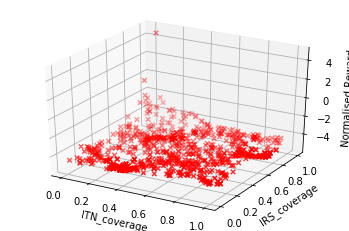

In [12]:
ResponseSurface(history.reshape(1000,3))

Let's observe the scatter plot for each generation reward vector 

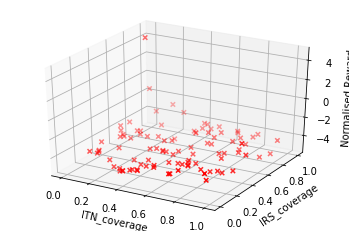

90.73117209199268


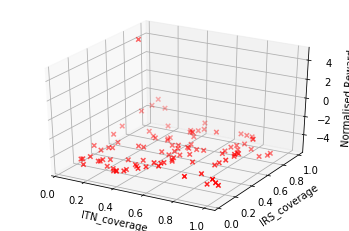

98.17305495866098


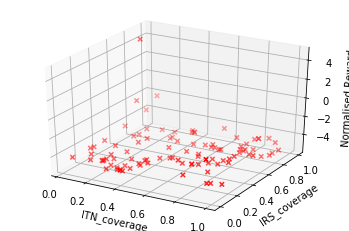

101.14799601801434


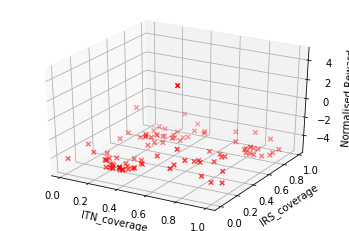

103.14701669405484


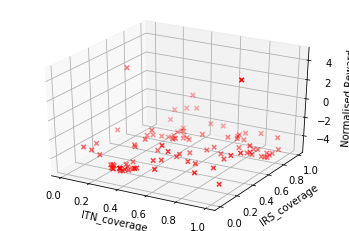

97.87907677220639


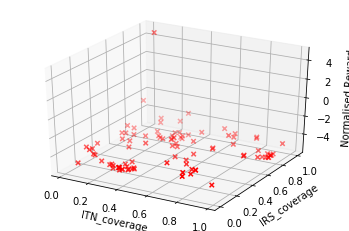

109.97607168947772


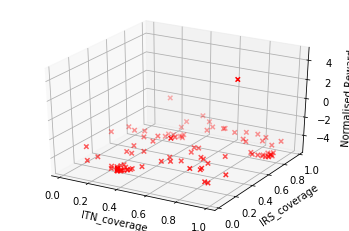

102.20769446035781


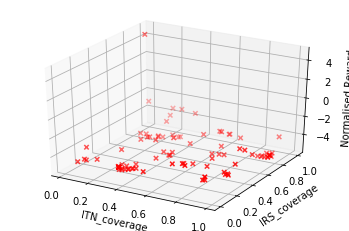

110.46690209351806


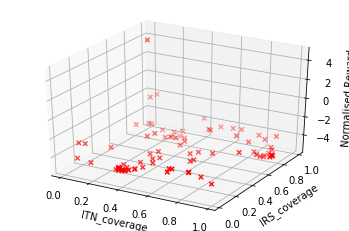

106.2951251296457


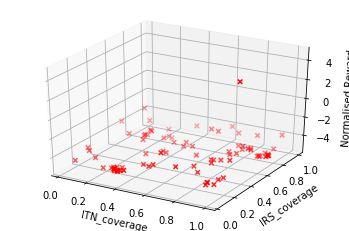

106.80368500612741


In [13]:
for i in history:
    ResponseSurface(i)
    print(i[:,-1].max())

And finally we are going to visialize the 10 generations in a box plot

{'whiskers': [<matplotlib.lines.Line2D at 0x117d1dfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x117cef978>,
 'boxes': [<matplotlib.lines.Line2D at 0x117d1de80>,
 'medians': [<matplotlib.lines.Line2D at 0x117cefda0>,
 'fliers': [<matplotlib.lines.Line2D at 0x117d10390>,
 'means': []}

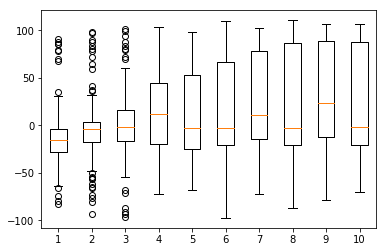

In [14]:
plt.boxplot([i[:,-1] for i in history])

## Now time to try and break it! 

You're now free to explore! Given the code snippets of how to post single actions.
Several methods, approaches or algorithms may stand to benefit the uses of high bandwidth computation for machine learning.

In [5]:
# import argparse
# import numpy as np
# from netsapi.environment import *
# from netsapi.location import *
# from netsapi.visualisation import *
# import os
# from sys import exit, exc_info, argv
# from multiprocessing import Pool, current_process
# import numpy as np
# from es import SimpleGA, RemyGA

# import timeit;
# ts = timeit.time.time()

# parser = argparse.ArgumentParser()
# parser.add_argument('--uri', default="http://9.131.184.201:9877", help='the uri to be used for the task clerk')
# parser.add_argument('--user', default="6e5d79ae637f41508228b28d0c5523f4", help='the userId provided to you upon registration')
# parser.add_argument('--location', default="iaai18valid_int_100000", help='the scenario file used for the experiments')
# parser.add_argument('--timeout', default=1800, help='a value proportional to the delay needed between polling', type=int)
# parser.add_argument('--batch', default=90, help='the number of jobs submitted concurrently', type=int)
# parser.add_argument('--resolution', default="medium", help='the population resolution used for the experiments (low|medium|high|test)')

# args = parser.parse_args()
# exp_location, timeout, baseuri, userId, realworkercount, resolution = args.location, args.timeout, args.uri, args.user, args.batch, args.resolution

popsize=50
num_real_paramters = 2
width = 10
num_paramters = num_real_paramters * width
num_generations = 10

# filename = "%s-%d-%d-%s-%s.npy"%(os.path.splitext(__file__)[0],ts,popsize,exp_location,resolution)

# locations = showLocations(baseuri);
# locationId = getLocationId(locations, exp_location)

#converts from binary representation to the actual action
def RealAction(action):
    realaction=()
    for i in range(int(num_paramters/width)):
        a1 = np.array(action[i*width:(i+1)*width])
        realaction = realaction + (a1.dot(2**np.arange(a1.size)[::-1])/pow(2,width),)
    realaction = np.round(realaction,3);
    return realaction

def individual_get_score(action):
    name_s=current_process().name
    id = np.mod(int(name_s.split("-")[1]),realworkercount)
    
    try:
        envId = initEnv(locationId, userId, resolution,baseuri)
        reward = postAction(envId, RealAction(action[1]), baseuri, False, timeout)
    except:
        print(exc_info(),action, envId)
        reward = None;
    
    return (action[0],reward)

def postActionWrapper(action):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
        id = -1
    try:
        envId = initEnv(locationId, userId, resolution, baseuri);
        posted = postAction(envId, RealAction(action[1]), baseuri, True, timeout)
    except:
        print(exc_info(),action)
    envId if posted else None
    return (action[0], envId)

def getStatusWrapper(envId):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
        id = -1
    try:
        status = getStatus(envId[1], baseuri)
    
    except:
        print(exc_info(),envId)
        status = None;
    
    return (envId[0], status)

def getRewardWrapper(envId):
    name_s=current_process().name
    if  "-" in name_s:
        id = np.mod(int(name_s.split("-")[1]),realworkercount)
    else:
        id = -1
    try:
        reward = getReward(envId[1], baseuri)
    except:
        print(exc_info(),envId)
        reward = None;
    return (envId[0], reward)

def map(function, data):
    pool = Pool(realworkercount)
    result = pool.map(function, data, chunksize=1)
    pool.close()
    pool.join()
    idx = []
    r = []
    for i in result:
        r.append(i[1])
        idx.append(i[0])
    return np.array(idx), np.array(r)

def evaluateNonBlocking(data, coverage, timeout=0):
    try:
        completed = []
        rewards = np.empty((data.shape[0]))
        rewards[:] = np.nan
        completed_new = np.empty((data.shape[0]))
        completed_new[:] = False
        
        env_idx, envs = map(postActionWrapper, zip(np.arange(data.shape[0]),data))
        
        while completed_new.sum() < float(coverage)*data.shape[0]:
            tmp_envs = envs[completed_new == False]
            tmp_env_idx = env_idx[completed_new == False]
            sta_idx, statii = map(getStatusWrapper, zip(tmp_env_idx, tmp_envs) )
            completed_new[sta_idx] = statii == 'true'
            timeit.time.sleep(timeout)

        if True:
            compl_idx= [i for i,v in enumerate(completed_new) if v]
            reward_idx, rewardsxx = map(getRewardWrapper,zip(compl_idx, envs[compl_idx]))
            for i,v in enumerate(rewardsxx):
                rewards[reward_idx[i]] = v
        else:
            for i,v in enumerate(completed_new):
                if v:
                   rewards[i] = getRewardWrapper((i,envs[i]))[1]

        val = rewards
    except:
        print(exc_info(),data)
        val = None
    return val

def evaluate(data):
    if len(data.shape) == 2: #vector of chromosomes
        pool = Pool(realworkercount)
        result = pool.map(individual_get_score, zip(np.arange(data.shape[0]),data))
        pool.close()
        pool.join()
        realResult = np.empty(len(result))
        for i,v in result:
            realResult[i] = v
        result = realResult
    else:
        result = individual_get_score(data)
    return result

def mutate(chromosome):
    mutation_rate = .002
    for j in range(chromosome.shape[0]):
        r = np.random.rand(1);
        if(r > mutation_rate):
            chromosome[j] = int(np.invert(bool(chromosome[j])));
    return chromosome

def make_random_individuals(x,y):
    value=np.random.choice([0, 1], size=(x,y));
    return value

def boundary(individual):
    processed = individual%(1+np.finfo(float).eps)
    return processed

solver = RemyGA(num_paramters,         # number of model parameters
                random_individuals_fcn=make_random_individuals,
                mutate_fcn = mutate,
                sigma_init=1,          # initial standard deviation
                popsize=popsize,       # population size
                elite_ratio=0.3,       # percentage of the elites
                forget_best=False,     # forget the historical best elites
                weight_decay=0.00,     # weight decay coefficient
                )

history=  np.empty(shape=(num_generations, solver.popsize, solver.num_params+1))
for i in range(num_generations):
    try:
        # ask for a set of random candidate solutions to be evaluated
        solutions = solver.ask(boundary)
        # calculate the reward for each given solution using our own method
        rewards = evaluate(solutions)
#        rewards = evaluateNonBlocking(solutions, .9);
        solver.tell(rewards)
        
        # get best parameter, reward from ES
        reward_vector = solver.result()
        print(RealAction(reward_vector[0]), reward_vector[1], i, num_generations)
        history[i,:,:] = np.hstack((solutions,np.array(rewards).reshape(-1,1)))
#         np.save('results/%s'%(filename), history)
    except (KeyboardInterrupt, SystemExit):
        print(exc_info())

#print(ts,timeit.time.time())
'''
    ResponseSurface(history.reshape(num_generations*solver.popsize,solver.num_params+1))
    
    for i in history:
    ResponseSurface(i)
    print(i[:,-1].max())
    
    plt.boxplot([i[:,-1] for i in history])
    '''

# ## Now time to try and break it!

# You're now free to explore! Given the code snippets of how to post single actions.
# Several methods, approaches or algorithms may stand to benefit the uses of high bandwidth computation for machine learning.

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd123", "userId": "3bbb54d8-04ea-455f-b364-9dfde49167f7", "resolution": "test"}
{"locationId": "abcd

'\n    ResponseSurface(history.reshape(num_generations*solver.popsize,solver.num_params+1))\n    \n    for i in history:\n    ResponseSurface(i)\n    print(i[:,-1].max())\n    \n    plt.boxplot([i[:,-1] for i in history])\n    '

In [6]:
newdata=history.reshape(num_generations*solver.popsize,solver.num_params+1)

In [7]:
newdata2=np.empty(shape=(500,3))
for i,v in enumerate(newdata):
    newdata2[i,:]=np.array(list(RealAction(v[:20])) + [newdata[i,-1]])
print(newdata2)

[[ 2.97000000e-01  8.80000000e-01  8.19627362e+00]
 [ 9.52000000e-01  7.79000000e-01  1.02335721e+02]
 [ 1.80000000e-02  4.83000000e-01 -2.33637443e+01]
 ...
 [ 6.60000000e-02  2.02000000e-01 -2.92932791e+01]
 [ 6.60000000e-02  2.02000000e-01 -2.92932791e+01]
 [ 6.60000000e-02  2.02000000e-01 -3.14072271e+01]]


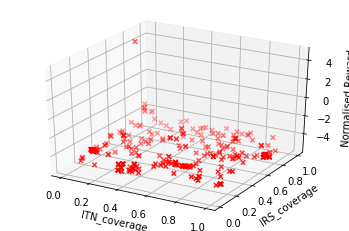

In [8]:
ResponseSurface(newdata2)

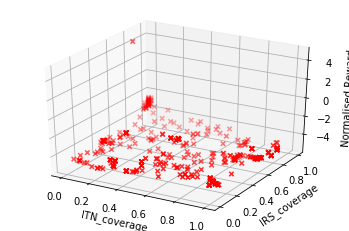

In [43]:
ResponseSurface(newdata2)

Q= [[ 2.97000000e-01  8.80000000e-01  8.19627362e+00]
 [ 9.52000000e-01  7.79000000e-01  1.02335721e+02]
 [ 1.80000000e-02  4.83000000e-01 -2.33637443e+01]
 ...
 [ 6.60000000e-02  2.02000000e-01 -2.92932791e+01]
 [ 6.60000000e-02  2.02000000e-01 -2.92932791e+01]
 [ 6.60000000e-02  2.02000000e-01 -3.14072271e+01]]


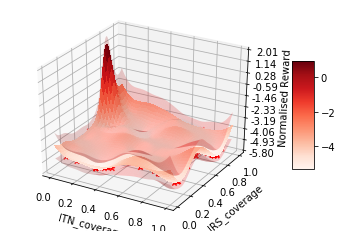

In [10]:
import sys, os
import numpy as np
import tensorflow as tf
import gpflow
import math
import numpy.ma as ma

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


GP_ls = 0.2
mask_size = 1
steps = int(math.ceil(100*GP_ls))# 1% resolution
n = int(math.ceil(steps/GP_ls))

Q = newdata2
print('Q=', Q)
# Q2 = np.load(file2)
# # # Q3 = np.load(file3)
# Q = np.concatenate((Q,Q2), axis=0)


# q = np.shape(Q)
# print('shape=', q)
# print('len=', len(q))

# if len(q)>2:
#     Q = np.reshape(Q,(q[0]*q[1],q[2]))
#     print('Q=', Q)

XYg = Q[:,(0,1)][Q[:,0]>.0, :]
# print 'XYg=',XYg
Z = Q[:,2][Q[:,0]>.0]
Z = Z.reshape(-1,1)

#Normalise
Z = Z - np.amin(Z) + 0.01 #set max at zero

Z = -np.log(Z)



##Plotting data
fig = plt.figure()
ax = fig.gca(projection='3d')
#plt.hold(True)
ax.scatter(XYg[:,0], XYg[:,1], Z, c = 'r', marker = 'x')

ax.set_xlabel('ITN_coverage')
ax.set_ylabel('IRS_coverage')
ax.set_zlabel('Normalised Reward')
#
#Fitting GP
k = gpflow.kernels.Matern52(2, lengthscales=0.2)
m = gpflow.models.GPR(XYg, Z, kern=k)
m.likelihood.variance = 0.05
# print m
# gpflow.train.ScipyOptimizer().minimize(m)
# m.optimize()
# print m
n=100

xitn = np.linspace(XYg[:,0].min(),XYg[:,0].max(),n)#take from Action and time space
xirs = np.linspace(XYg[:,1].min(),XYg[:,1].max(),n)
x, y = np.meshgrid(xitn, xirs)

xg = x.reshape(-1,1)
yg = y.reshape(-1,1)
#
xyg = np.concatenate((xg, yg), axis=1)

mean, var = m.predict_y(xyg)

z = mean.reshape((n,n))
v_up = mean[:,0] + 2*np.sqrt(var[:,0])
v_down = mean[:,0] - 2*np.sqrt(var[:,0])
# print 'v_up=',v_up
v_up_plot = v_up.reshape((n,n))
v_down_plot = v_down.reshape((n,n))
#
surf = ax.plot_surface(x, y, z, cmap=cm.Reds, linewidth=0, antialiased=False)

#Plot Variances
ax.plot_surface(x,y,v_up_plot, alpha = 0.2, color = 'r')
ax.plot_surface(x,y,v_down_plot, alpha = 0.2, color = 'r')

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_zlim(np.amin(v_down_plot),np.amax(v_up_plot))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
#
plt.show()